In [1]:
import os
import re
import math
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from glob import glob
from tools.settings import *
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tools.train_val_test_spliter import split
import collections
from collections import Counter

In [ ]:
split()

In [3]:
train = pd. read_csv(os.path.join(dataset_path, "train.csv"))
test = pd. read_csv(os.path.join(dataset_path, "test.csv"))
val = pd. read_csv(os.path.join(dataset_path, "val.csv"))
print(train.shape)
print(test.shape)
print(val.shape)

(334, 2)
(110, 2)
(110, 2)


In [5]:
def convert_to_frame(data, folder_name):
    '''
    Generated filenames format dataset_path/folder_name/video_name_frame{number}_action.jpg
    '''
    directory = os.path.join(dataset_path, folder_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(data.shape[0])):
        video_file = data['Video_url'][i]
        action = data['action'][i]
        video_name_list = video_file.split('/')[-1].split('.')
        video_name_list = video_name_list[:-1]
        video_name = ""
        for n in video_name_list:
            video_name += n
        # capturing the video from the given path
        capture = cv2.VideoCapture(video_file) 
        #frame rate
        frame_rate = capture.get(5)
        count = 0
        while(capture.isOpened()):
            #current frame number
            frame_id = capture.get(1) 
            read_correctly, frame = capture.read()
            if not read_correctly:
                break
            if (frame_id % math.floor(frame_rate) == 0):
                # storing the frames in a new folder named train_1
                filename = directory + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
                count += 1
                cv2.imwrite(filename, frame)
        capture.release()
    print("Successfully Converted")

In [ ]:
convert_to_frame(train, train_frames_path_name)

In [ ]:
convert_to_frame(val, val_frames_path_name)

In [4]:
def create_paths_csv(directory, file_name):
    images = os.listdir(directory)
    images_path_list = []
    images_action_list = [] 
    for image in images:
        images_path_list.append(directory + image)
        images_action_list.append(image.split('.')[0].split('_')[-1])
    df = pd.DataFrame()
    df['image'] = images_path_list
    df['action'] = images_action_list
    print(os.path.join(dataset_path, file_name+'.csv'))
    df.to_csv(os.path.join(dataset_path, file_name+'.csv'), index=False)

In [6]:
create_paths_csv(train_frames_path, train_frames_path_name)

G:/CSGO Video Analyis/Data\train_frames.csv


In [7]:
create_paths_csv(val_frames_path, val_frames_path_name)

G:/CSGO Video Analyis/Data\val_frames.csv


In [8]:
train_image = pd.read_csv(os.path.join(dataset_path, 'train_frames.csv'))
train_image

,image,action
0,G:/CSGO Video Analyis/Data\train_frames\death_...,death
1,G:/CSGO Video Analyis/Data\train_frames\death_...,death
2,G:/CSGO Video Analyis/Data\train_frames\death_...,death
3,G:/CSGO Video Analyis/Data\train_frames\death_...,death
4,G:/CSGO Video Analyis/Data\train_frames\death_...,death
...,...,...
1206,G:/CSGO Video Analyis/Data\train_frames\weapon...,NoAction
1207,G:/CSGO Video Analyis/Data\train_frames\weapon...,NoAction
1208,G:/CSGO Video Analyis/Data\train_frames\weapon...,NoAction
1209,G:/CSGO Video Analyis/Data\train_frames\weapon...,NoAction


In [9]:
val_image = pd.read_csv(os.path.join(dataset_path, 'val_frames.csv'))
val_image

,image,action
0,G:/CSGO Video Analyis/Data\val_frames\death_10...,death
1,G:/CSGO Video Analyis/Data\val_frames\death_10...,death
2,G:/CSGO Video Analyis/Data\val_frames\death_10...,death
3,G:/CSGO Video Analyis/Data\val_frames\death_10...,death
4,G:/CSGO Video Analyis/Data\val_frames\death_10...,death
...,...,...
419,G:/CSGO Video Analyis/Data\val_frames\weaponr8...,NoAction
420,G:/CSGO Video Analyis/Data\val_frames\weaponsc...,NoAction
421,G:/CSGO Video Analyis/Data\val_frames\weaponsc...,NoAction
422,G:/CSGO Video Analyis/Data\val_frames\weaponsc...,NoAction


In [10]:
action_values = list(train_image['action'].unique())
action_values

['death', 'kill', 'NoAction', 'smoke']

In [11]:
def create_class_columns(df):
    for value in action_values:
        df[value] = np.where(df['action'].str.contains(value), 1, 0)
    df.drop('action', axis='columns', inplace=True)

In [12]:
create_class_columns(train_image)
train_image.head()

,image,death,kill,NoAction,smoke
0,G:/CSGO Video Analyis/Data\train_frames\death_...,1,0,0,0
1,G:/CSGO Video Analyis/Data\train_frames\death_...,1,0,0,0
2,G:/CSGO Video Analyis/Data\train_frames\death_...,1,0,0,0
3,G:/CSGO Video Analyis/Data\train_frames\death_...,1,0,0,0
4,G:/CSGO Video Analyis/Data\train_frames\death_...,1,0,0,0


In [13]:
create_class_columns(val_image)
val_image.head()

,image,death,kill,NoAction,smoke
0,G:/CSGO Video Analyis/Data\val_frames\death_10...,1,0,0,0
1,G:/CSGO Video Analyis/Data\val_frames\death_10...,1,0,0,0
2,G:/CSGO Video Analyis/Data\val_frames\death_10...,1,0,0,0
3,G:/CSGO Video Analyis/Data\val_frames\death_10...,1,0,0,0
4,G:/CSGO Video Analyis/Data\val_frames\death_10...,1,0,0,0


In [14]:
def convert_to_array_and_split(image_data):
    image_value = []
    for i in tqdm(range(image_data.shape[0])):
        img = image.load_img(image_data['image'][i], target_size=(224,224,3))
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img / 255
        image_value.append(img)

    X = np.array(image_value)
    y = image_data
    y.drop('image', axis='columns', inplace=True)
    return X, y

In [15]:
X_train, y_train = convert_to_array_and_split(train_image)
print(X_train.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1211/1211 [00:27<00:00, 43.55it/s]


(1211, 224, 224, 3)


In [16]:
X_val, y_val = convert_to_array_and_split(val_image)
print(X_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 424/424 [00:08<00:00, 52.66it/s]


(424, 224, 224, 3)


In [20]:
model = Sequential()
# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding="valid", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation = "relu"))
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
'''
# 5th Convolutional Layer
model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
# 6th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
# 7th Convolutional Layer
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", activation = "relu"))
'''
# Max Pooling
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding="valid"))
# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(units = 9216, activation = "relu"))
# 2nd Fully Connected Layer
model.add(Dense(units = 4096, activation = "relu"))
# 3rd Fully Connected Layer
model.add(Dense(4096, activation = "relu"))

# Output Layer
model.add(Dense(4, activation = "softmax")) #As we have two classes
model.summary()
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 384)        

In [21]:
from keras.callbacks import ModelCheckpoint
mcp_weight = ModelCheckpoint('New_Network.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [22]:
history=model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[mcp_weight], batch_size=128)

Epoch 1/30
10/10 [==============================] - 4s 262ms/step - loss: 15.7789 - accuracy: 0.2738 - val_loss: 1.3797 - val_accuracy: 0.2547
Epoch 2/30
10/10 [==============================] - 2s 220ms/step - loss: 1.3733 - accuracy: 0.2735 - val_loss: 1.6637 - val_accuracy: 0.2571
Epoch 3/30
10/10 [==============================] - 2s 219ms/step - loss: 1.4651 - accuracy: 0.2785 - val_loss: 1.3769 - val_accuracy: 0.3090
Epoch 4/30
10/10 [==============================] - 2s 215ms/step - loss: 1.3742 - accuracy: 0.3159 - val_loss: 1.3771 - val_accuracy: 0.3090
Epoch 5/30
10/10 [==============================] - 2s 215ms/step - loss: 1.3653 - accuracy: 0.3259 - val_loss: 1.3759 - val_accuracy: 0.3090
Epoch 6/30
10/10 [==============================] - 2s 221ms/step - loss: 1.3715 - accuracy: 0.3191 - val_loss: 1.3745 - val_accuracy: 0.3090
Epoch 7/30
10/10 [==============================] - 2s 221ms/step - loss: 1.3732 - accuracy: 0.3097 - val_loss: 1.3782 - val_accuracy: 0.3090
Epoch

In [23]:
model.load_weights("New_Network.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 384)        

In [24]:
from scipy import stats as s
predict_vgg16 = []
actual = []
dict_vgg16 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    prediction_images_copy = prediction_images
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    #prediction_images = base_model_vgg16.predict(prediction_images)
    # converting features in one dimensional array
    #prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_vgg16[video_name] = prediction_test
        #print(prediction_test)
        #print(action)
        #print(video_name)
    
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_vgg16.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [03:08<00:00,  1.71s/it]


In [25]:
print(dict_vgg16)

{'smoke_40 ': 'death', 'weaponm4_06': 'smoke', 'kill_50 ': 'NoAction', 'death_63 ': 'kill', 'smoke_21 ': 'NoAction', 'NoAction_89 ': 'death', 'NoAction_20 ': 'kill', 'weaponmp7_100 (2)': 'smoke', 'death_4 ': 'NoAction', 'death_40 ': 'NoAction', 'smoke_22 ': 'kill', 'smoke_33 ': 'NoAction', 'smoke_17 ': 'NoAction', 'NoAction_77 ': 'smoke', 'NoAction_6 ': 'kill', 'death_64 ': 'kill', 'death_129 ': 'NoAction', 'weaponp90_01': 'smoke', 'kill_47 ': 'death', 'NoAction_44 ': 'smoke', 'kill_1 ': 'NoAction', 'kill_70 ': 'smoke', 'death_66 ': 'NoAction', 'kill_29 ': 'death', 'death_36 ': 'NoAction', 'death_27 ': 'NoAction', 'death_11 ': 'NoAction', 'death_37 ': 'NoAction', 'death_53 ': 'kill', 'death_12 ': 'smoke', 'smoke_36 ': 'NoAction', 'kill_97 ': 'NoAction', 'smoke_9 ': 'kill', 'kill_40 ': 'NoAction', 'kill_39 ': 'NoAction', 'death_82 ': 'NoAction', 'kill_71 ': 'NoAction', 'NoAction_88 ': 'smoke', 'death_60 ': 'kill'}


In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_vgg16, actual)*100

64.54545454545455

In [27]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_vgg16, actual)*100
precision = precision_score(actual, predict_vgg16, average=None)
f1_score = f1_score(actual, predict_vgg16, average=None)
recall = recall_score(actual, predict_vgg16, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  64.54545454545455
Precision:  [0.55813953 0.75       0.72413793 0.63636364]
F1_score:  [0.63157895 0.57142857 0.71186441 0.65116279]
Recall:  [0.72727273 0.46153846 0.7        0.66666667]


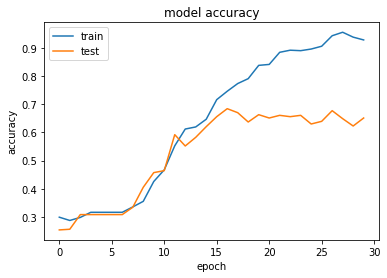

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

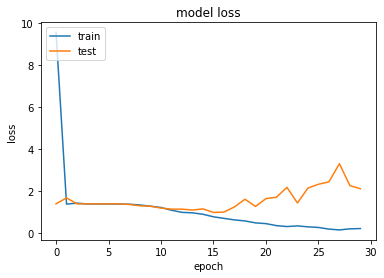

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()